# Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('ggplot')

#### Load Dataset

I've already split the data into train and test sets.

In [2]:
diamonds = pd.read_csv('../data/train.csv', index_col=0)

diamonds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40455 entries, 442 to 2733
Data columns (total 10 columns):
carat      40455 non-null float64
cut        40455 non-null object
color      40455 non-null object
clarity    40455 non-null object
depth      40455 non-null float64
table      40455 non-null float64
price      40455 non-null int64
x          40455 non-null float64
y          40455 non-null float64
z          40455 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.4+ MB


In [3]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
442,0.89,Premium,H,SI2,60.2,59.0,2815,6.26,6.23,3.76
50333,0.70,Very Good,D,SI1,64.0,53.0,2242,5.57,5.61,3.58
35653,0.31,Ideal,G,VVS2,62.7,57.0,907,4.33,4.31,2.71
9440,0.90,Very Good,H,VS1,62.3,59.0,4592,6.12,6.17,3.83
15825,1.01,Good,F,VS2,60.6,62.0,6332,6.52,6.49,3.94


#### Scatter Matrix

/home/benedict/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1080x1080 with 0 Axes>

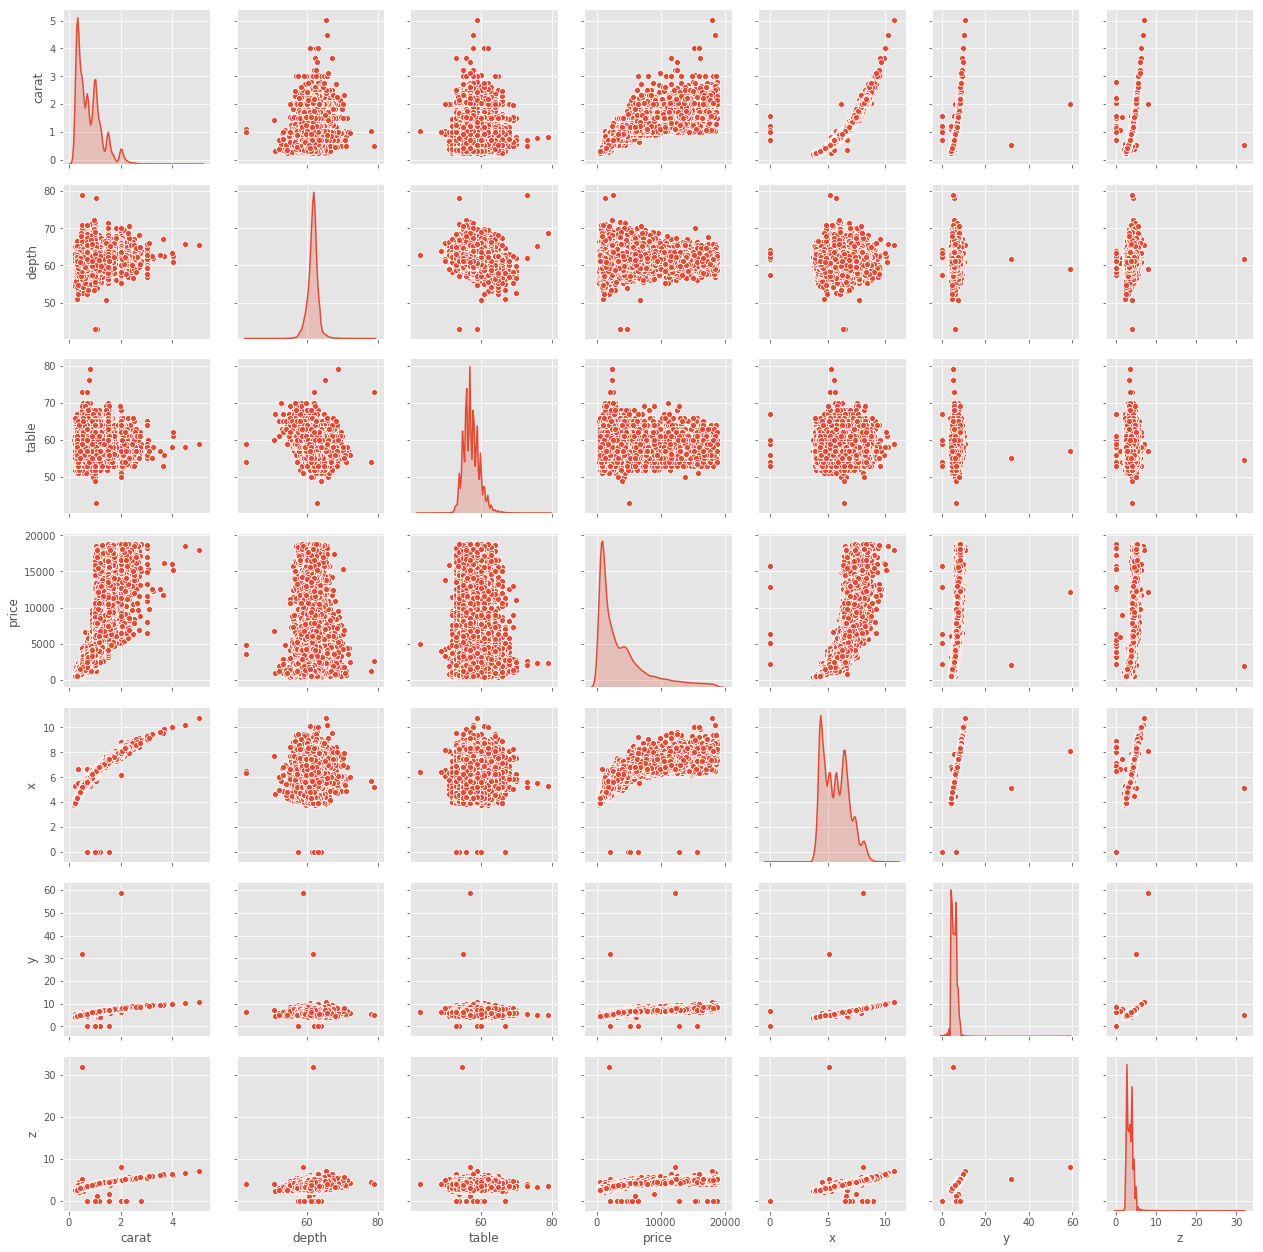

In [4]:
plt.figure(figsize=(15,15));
sns.pairplot(diamonds, diag_kind='kde');

## Univariate Analyses of Continuous Features

### `carat`

Intuitively, I expect `carat` to be have a strong relationship with `price`.

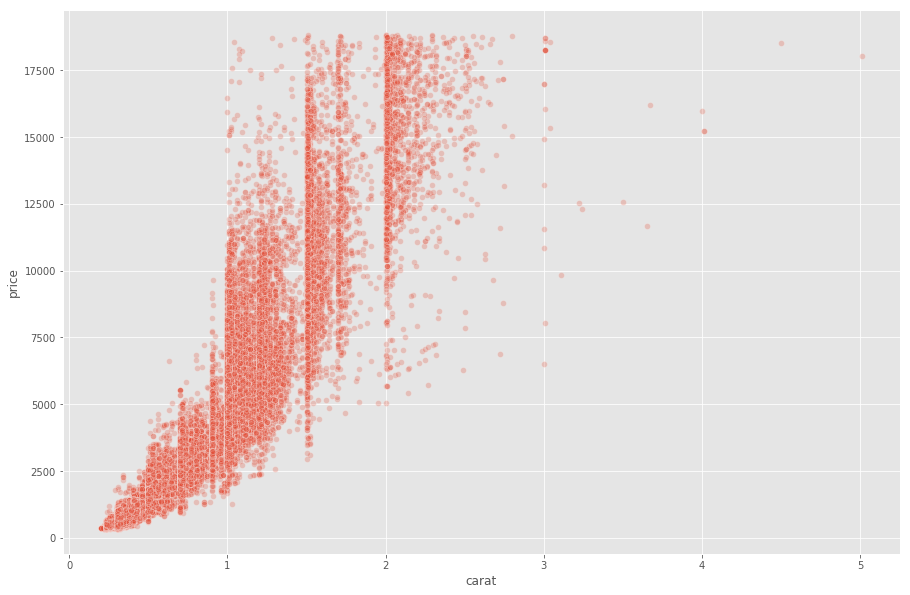

In [5]:
plt.figure(figsize=(15,10));
sns.scatterplot(x='carat', y='price', data=diamonds, alpha=0.25);

Looks relatively linear. There appears to be a heteroskedastic relationship between carat and price. I'll fit a univariate linear regression on price and carat and test the residuals with a Breusch-Pagan test.

####  Testing for Heteroskedasticity

In [6]:
import statsmodels.api as sm

In [7]:
y = diamonds['price'].values
X = sm.add_constant(diamonds['carat'].values)

lm_carat = sm.OLS(y, X)
lm_carat_fitted = lm_carat.fit()

lm_carat_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                 2.273e+05
Date:                Tue, 18 Sep 2018   Prob (F-statistic):               0.00
Time:                        15:57:46   Log-Likelihood:            -3.5458e+05
No. Observations:               40455   AIC:                         7.092e+05
Df Residuals:                   40453   BIC:                         7.092e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2249.1841     15.076   -149.194      0.000   -2278.733   -2219.636
x1          7745.2608     16.247    476.732      0.000    7713.417    7777.105
==============================================================================
Omnibus:                    10571.958   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           119237.641
Skew:                           0.935   Prob(JB):                         0.00
Kurtosis:                      11.200   Cond. No.                         3.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
resids = lm_carat_fitted.resid

f_stat, p_val, alt = sm.stats.diagnostic.het_goldfeldquandt(y, X)

print("F-statistic:", f_stat)
print("p-value:", p_val)

F-statistic: 0.9826393716744725
p-value: 0.8934893803484176


We fail to reject the null hypothesis that our data is homoskedastic.

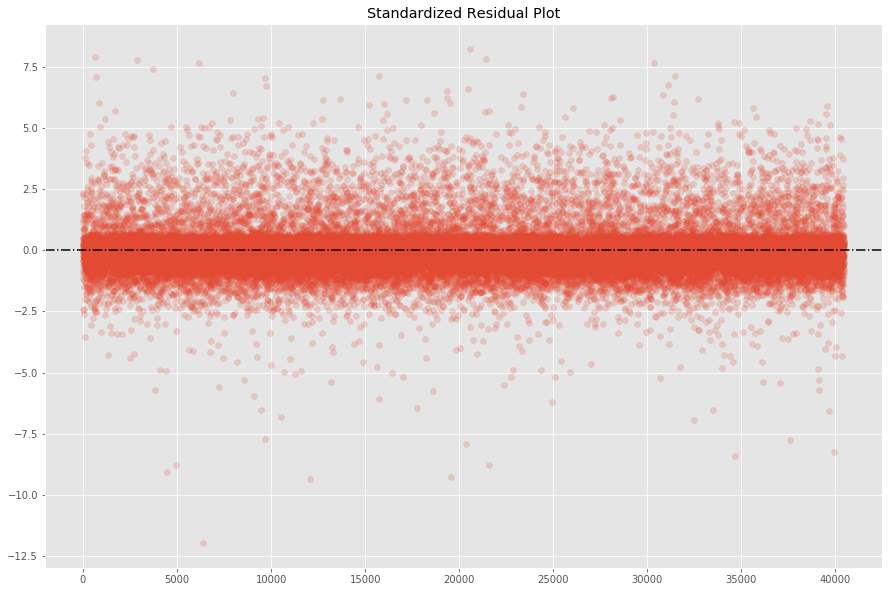

In [9]:
pearson_resids = lm_carat_fitted.resid_pearson

plt.figure(figsize=(15,10)); # I like big plots and I cannot lie
plt.scatter(x=range(len(resids)), y=pearson_resids, alpha=0.2);
plt.title("Standardized Residual Plot");
plt.axhline(c='black', ls='-.');

Looks good, let's move on.

#### Normal Distribution of Error

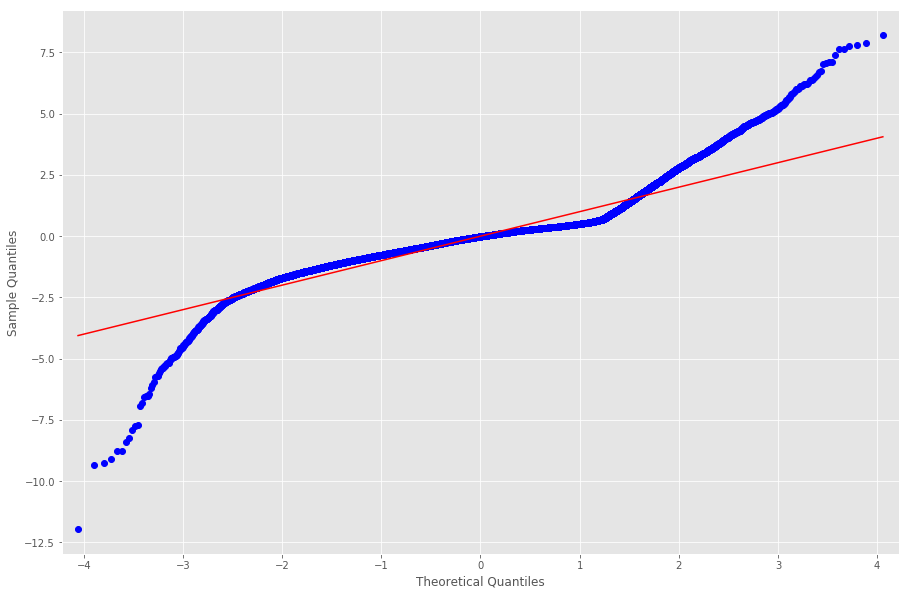

In [10]:
fig, ax = plt.subplots(figsize=(15,10));
sm.qqplot(pearson_resids, ax=ax, line='s');

Between this terrible looking Q-Q plot and the Jacques-Bera test, our error does not look normally distributed. Let's log transform this puppy.

#### Log-Transformation

In [11]:
lny = np.log(y)

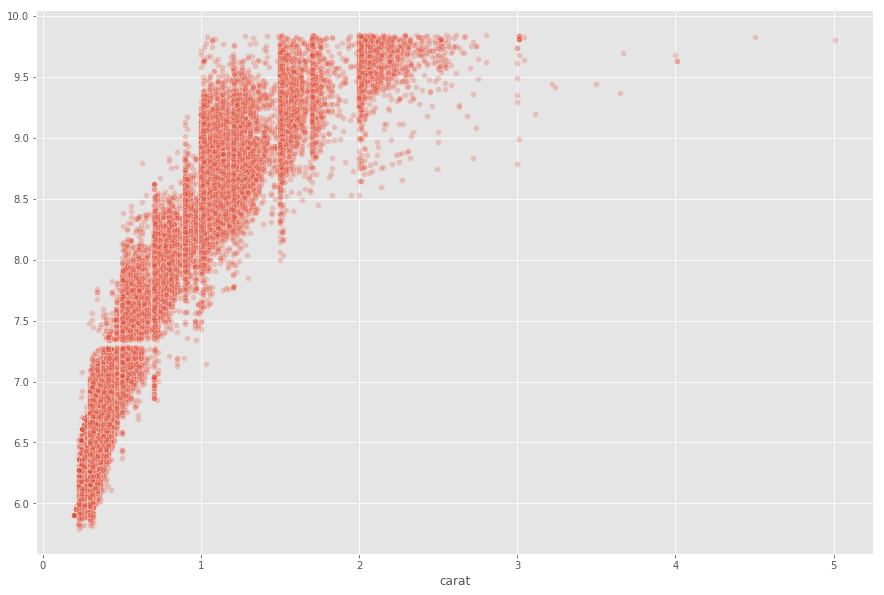

In [12]:
plt.figure(figsize=(15,10));
sns.scatterplot(x='carat', y=lny, data=diamonds, alpha=0.25);

This looks a lot better, quadratic probably.

In [13]:
lm_log_carat = sm.OLS(lny, X)
lm_log_carat_fitted = lm_log_carat.fit()

lm_log_carat_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                 2.225e+05
Date:                Tue, 18 Sep 2018   Prob (F-statistic):               0.00
Time:                        15:57:48   Log-Likelihood:                -20087.
No. Observations:               40455   AIC:                         4.018e+04
Df Residuals:                   40453   BIC:                         4.020e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2182      0.004   1607.929      0.000       6.211       6.226
x1             1.9659      0.004    471.701      0.000       1.958       1.974
==============================================================================
Omnibus:                     8509.126   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61393.797
Skew:                          -0.825   Prob(JB):                         0.00
Kurtosis:                       8.805   Cond. No.                         3.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

JB test is still significant (large sample size :\) but the stat is much lower. Let's look at residuals.

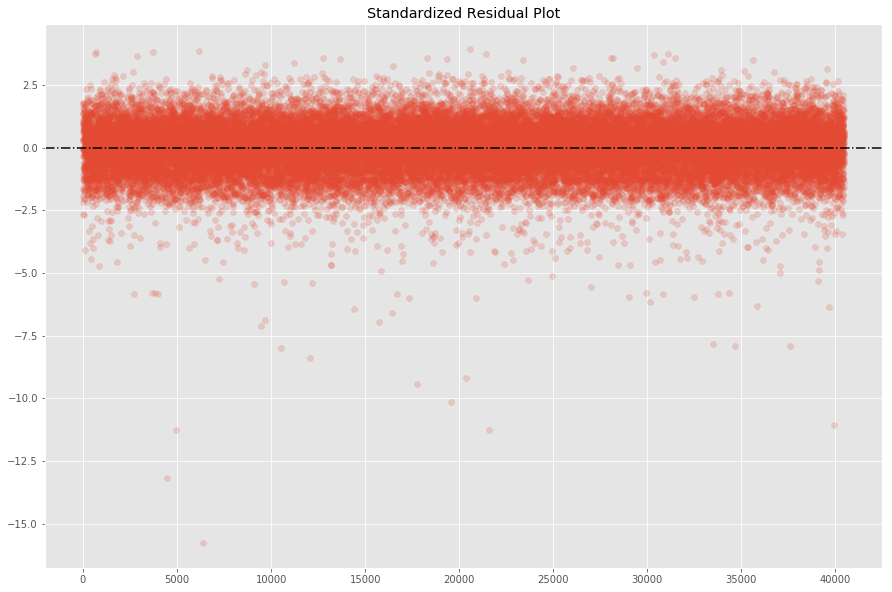

In [14]:
log_pearson_resids = lm_log_carat_fitted.resid_pearson

plt.figure(figsize=(15,10)); # I like big plots and I cannot lie
plt.scatter(x=range(len(resids)), y=log_pearson_resids, alpha=0.2);
plt.title("Standardized Residual Plot");
plt.axhline(c='black', ls='-.');

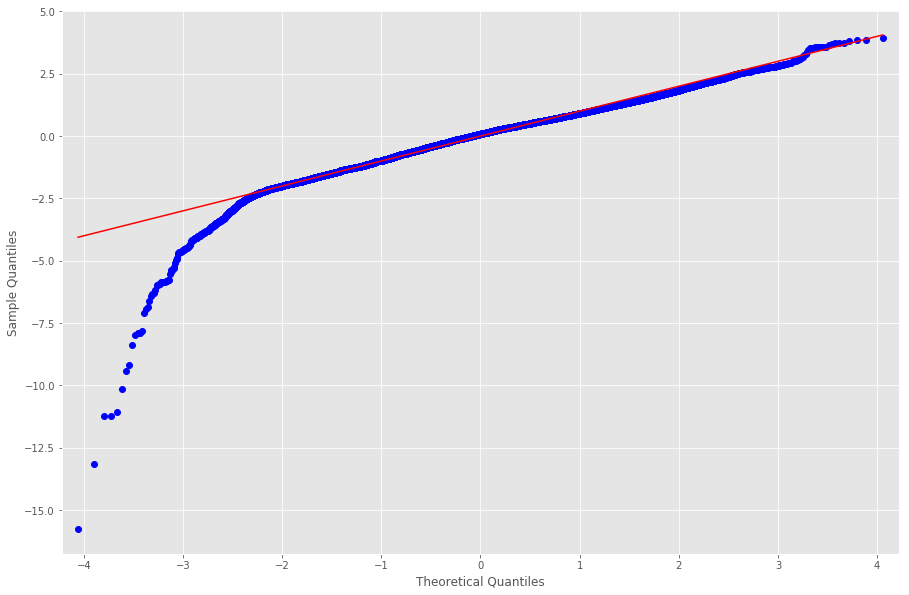

In [15]:
fig, ax = plt.subplots(figsize=(15,10));
sm.qqplot(log_pearson_resids, ax=ax, line='s');

Not perfect, but nothing is. Let's move on, it looks good enough. We will proceed using the natty log of price.

In [16]:
diamonds['lnprice'] = np.log(diamonds['price'])

#### Autocorrelation

Recall that our Durbin-Watson test statistic was 1.992, so we're good there.

#### Root Mean Square Error

We're gonna go ahead and use RMSE as our error metric, it's a classic.

In [17]:
np.sqrt(lm_log_carat_fitted.mse_resid)

0.39757191278565757

#### Conclusion
So our univariate analysis of carat and price shows we have an $R^2$ of 0.846 and an $MSE$ of 1.027, I guess we can call it a day! Just kidding. Let's check out our other features.

### `x`, `y`, `z`, `depth`,  and `table`

These all have to do with the dimensions and shape of the diamond, and even if there is some good stuff going on here I would bet all I got that there's a bunch of multicollinearity (amongst themselves and `carat`) as well. Let's check it out anyway.

### `x`

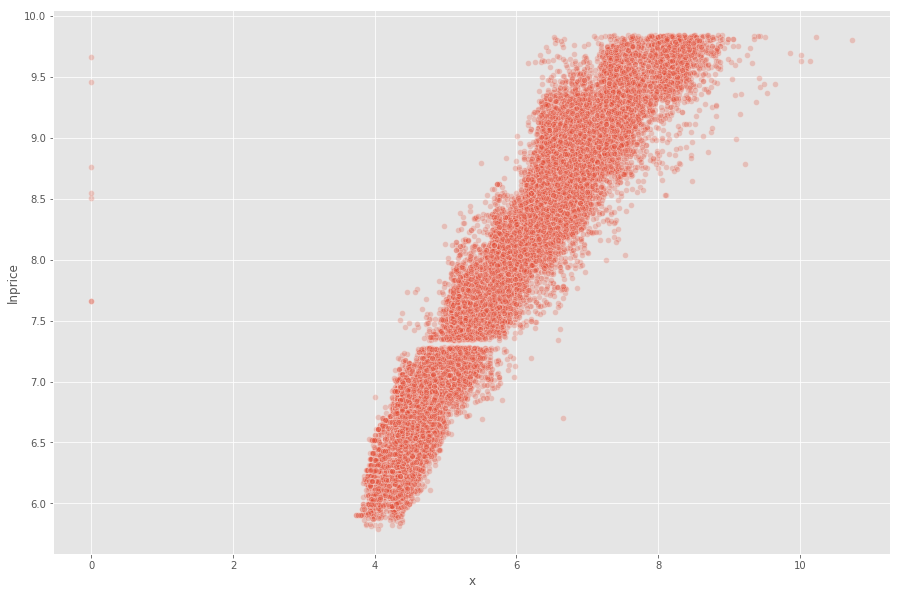

In [18]:
plt.figure(figsize=(15,10));
sns.scatterplot(x='x', y='lnprice', data=diamonds, alpha=0.25);

In [19]:
y = diamonds['lnprice'].values
X = sm.add_constant(diamonds['x'].values)

lm_x = sm.OLS(y, X)
lm_x_fitted = lm_x.fit()

lm_x_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                 4.461e+05
Date:                Tue, 18 Sep 2018   Prob (F-statistic):               0.00
Time:                        15:57:50   Log-Likelihood:                -7641.3
No. Observations:               40455   AIC:                         1.529e+04
Df Residuals:                   40453   BIC:                         1.530e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8319      0.008    374.650      0.000       2.817       2.847
x1             0.8646      0.001    667.884      0.000       0.862       0.867
==============================================================================
Omnibus:                    18494.728   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1505858.460
Skew:                           1.315   Prob(JB):                         0.00
Kurtosis:                      32.773   Cond. No.                         31.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Heteroskedasticity

In [20]:
resids = lm_x_fitted.resid

f_stat, p_val, alt = sm.stats.diagnostic.het_goldfeldquandt(y, X)

print("F-statistic:", f_stat)
print("p-value:", p_val)

F-statistic: 0.9690575014721821
p-value: 0.9872897128218692


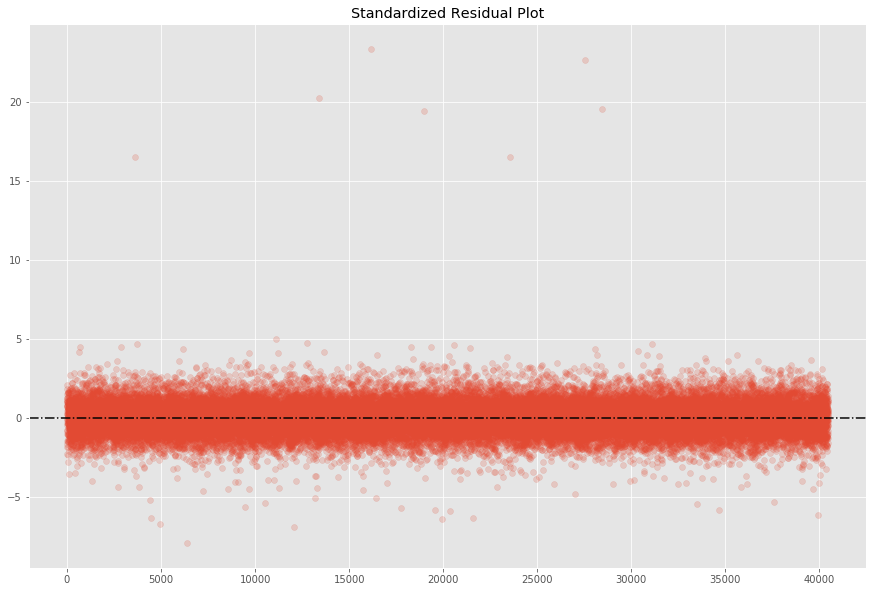

In [21]:
pearson_resids = lm_x_fitted.resid_pearson

plt.figure(figsize=(15,10)); 
plt.scatter(x=range(len(resids)), y=pearson_resids, alpha=0.2);
plt.title("Standardized Residual Plot");
plt.axhline(c='black', ls='-.');

#### Normal Distribution of Error

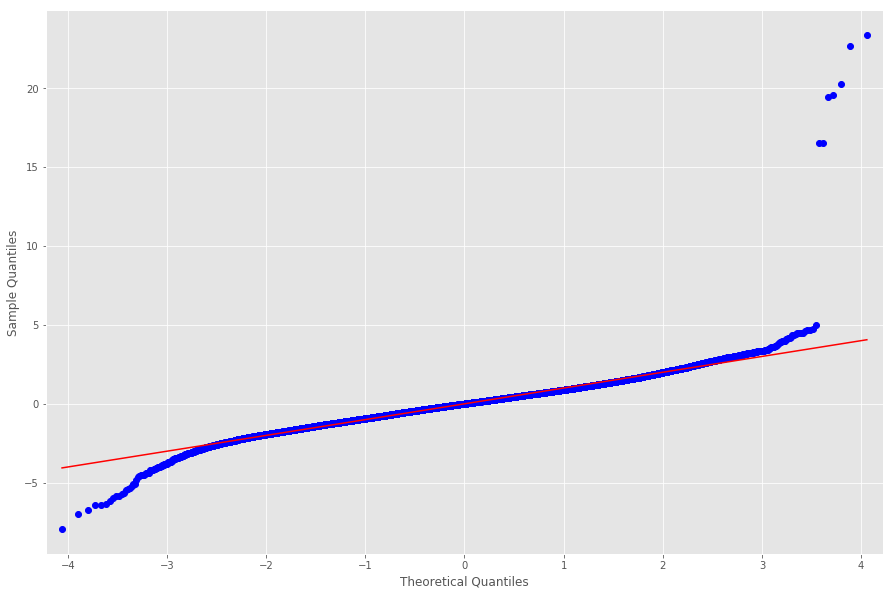

In [22]:
fig, ax = plt.subplots(figsize=(15,10));
sm.qqplot(pearson_resids, ax=ax, line='s');

Looks okay.

#### Autocorrelation

D-W stat at 1.996, so we are good to go.

#### Root Mean Square Error

In [23]:
np.sqrt(lm_x_fitted.mse_resid)

0.29228397852184196

### `y`

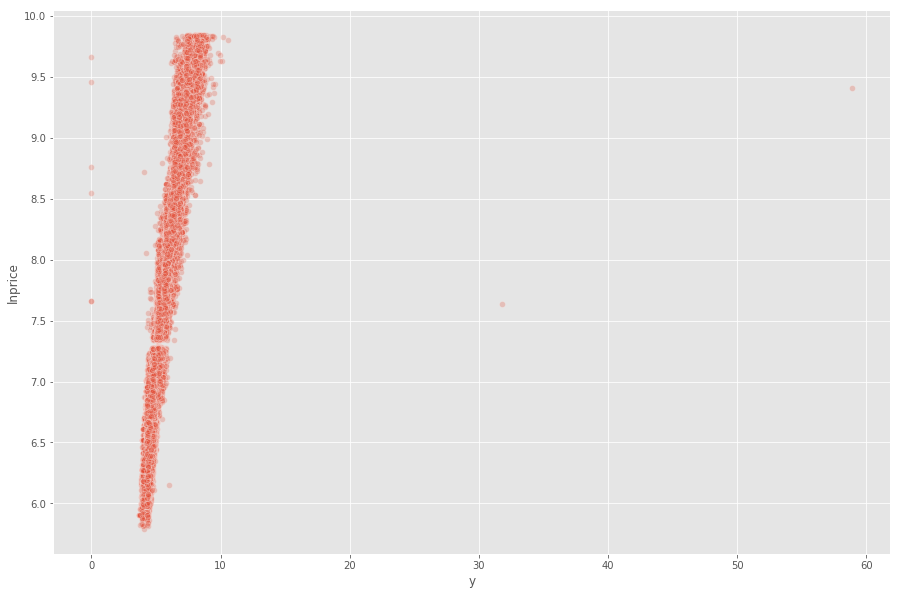

In [24]:
plt.figure(figsize=(15,10));
sns.scatterplot(x='y', y='lnprice', data=diamonds, alpha=0.25);

In [25]:
y = diamonds['lnprice'].values
X = sm.add_constant(diamonds['y'].values)

lm_y = sm.OLS(y, X)
lm_y_fitted = lm_y.fit()

lm_y_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                 2.532e+05
Date:                Tue, 18 Sep 2018   Prob (F-statistic):               0.00
Time:                        15:57:52   Log-Likelihood:                -17853.
No. Observations:               40455   AIC:                         3.571e+04
Df Residuals:                   40453   BIC:                         3.573e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1011      0.009    326.568      0.000       3.083       3.120
x1             0.8171      0.002    503.208      0.000       0.814       0.820
==============================================================================
Omnibus:                   115873.729   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      27543330712.595
Skew:                         -37.995   Prob(JB):                         0.00
Kurtosis:                    4044.578   Cond. No.                         30.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Heteroskedasticity

In [26]:
resids = lm_y_fitted.resid

f_stat, p_val, alt = sm.stats.diagnostic.het_goldfeldquandt(y, X)

print("F-statistic:", f_stat)
print("p-value:", p_val)

F-statistic: 2.2900405922748486
p-value: 0.0


Hmmm, doesn't look so good.

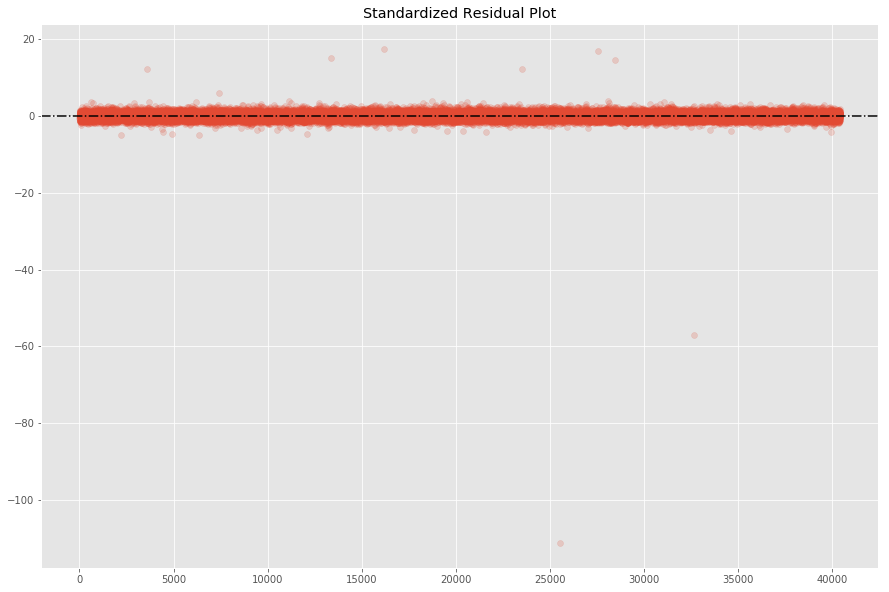

In [27]:
pearson_resids = lm_y_fitted.resid_pearson

plt.figure(figsize=(15,10)); 
plt.scatter(x=range(len(resids)), y=pearson_resids, alpha=0.2);
plt.title("Standardized Residual Plot");
plt.axhline(c='black', ls='-.');

Looks like it's just a couple of outliers messing it up.

#### Normal Distribution of Error

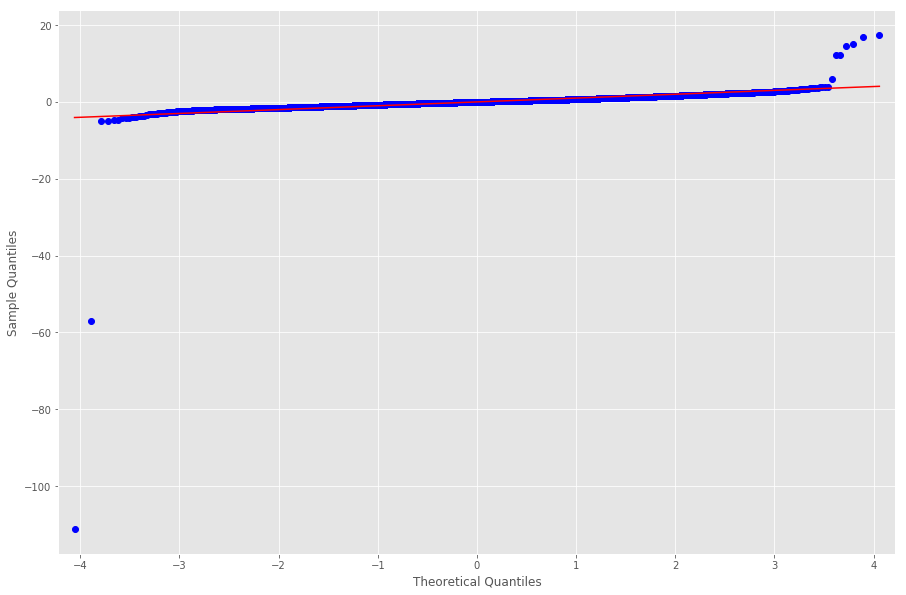

In [28]:
fig, ax = plt.subplots(figsize=(15,10));
sm.qqplot(pearson_resids, ax=ax, line='s');

Looks bad

#### Autocorrelation

D-W stat at 1.990, so we are good to go.

#### Root Mean Square Error

In [29]:
np.sqrt(lm_y_fitted.mse_resid)

0.3762058780240932

### `z`

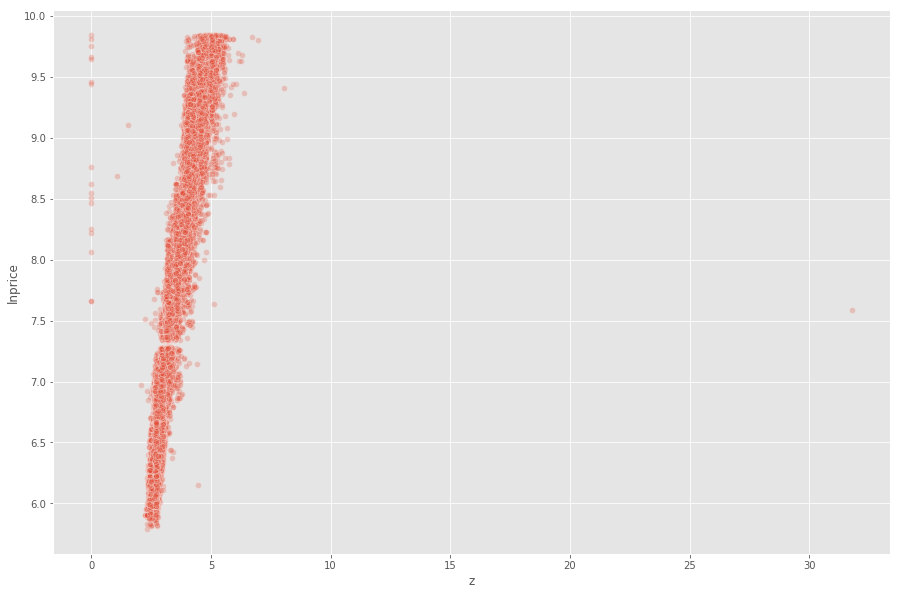

In [30]:
plt.figure(figsize=(15,10));
sns.scatterplot(x='z', y='lnprice', data=diamonds, alpha=0.25);

In [31]:
y = diamonds['lnprice'].values
X = sm.add_constant(diamonds['z'].values)

lm_z = sm.OLS(y, X)
lm_z_fitted = lm_z.fit()

lm_z_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                 2.571e+05
Date:                Tue, 18 Sep 2018   Prob (F-statistic):               0.00
Time:                        15:57:54   Log-Likelihood:                -17586.
No. Observations:               40455   AIC:                         3.518e+04
Df Residuals:                   40453   BIC:                         3.519e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0891      0.009    326.976      0.000       3.071       3.108
x1             1.3275      0.003    507.058      0.000       1.322       1.333
==============================================================================
Omnibus:                    97280.810   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      11314990731.318
Skew:                         -23.832   Prob(JB):                         0.00
Kurtosis:                    2593.437   Cond. No.                         19.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Heteroskedasticity

In [32]:
resids = lm_z_fitted.resid

f_stat, p_val, alt = sm.stats.diagnostic.het_goldfeldquandt(y, X)

print("F-statistic:", f_stat)
print("p-value:", p_val)

F-statistic: 0.6140460447889232
p-value: 0.9999999999999999


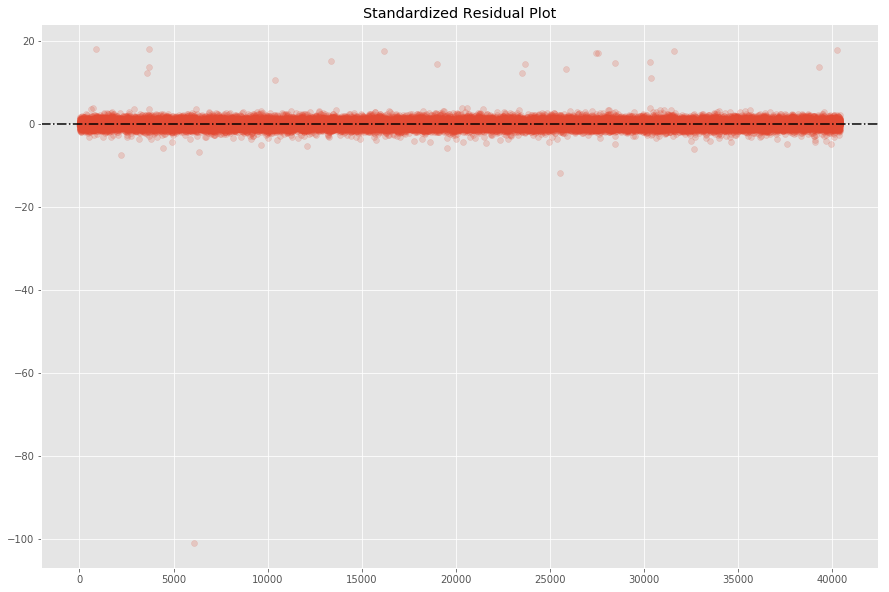

In [33]:
pearson_resids = lm_z_fitted.resid_pearson

plt.figure(figsize=(15,10)); 
plt.scatter(x=range(len(resids)), y=pearson_resids, alpha=0.2);
plt.title("Standardized Residual Plot");
plt.axhline(c='black', ls='-.');

Looks like it's just a couple of outliers messing it up.

#### Normal Distribution of Error

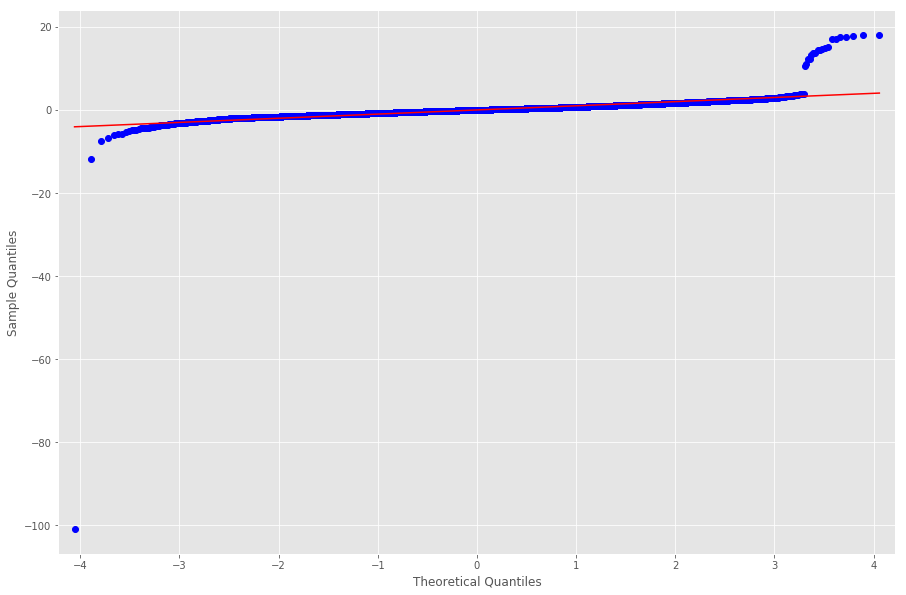

In [34]:
fig, ax = plt.subplots(figsize=(15,10));
sm.qqplot(pearson_resids, ax=ax, line='s');

Looks  fine

#### Autocorrelation

D-W stat at 1.994, so we are good to go.

#### Root Mean Square Error

In [35]:
np.sqrt(lm_z_fitted.mse_resid)

0.3737392440156936

### `depth`

This one is literally a function of `x`, `y`, and `z`.

<center>$depth = \displaystyle \frac{2z}{x + y}$</center>

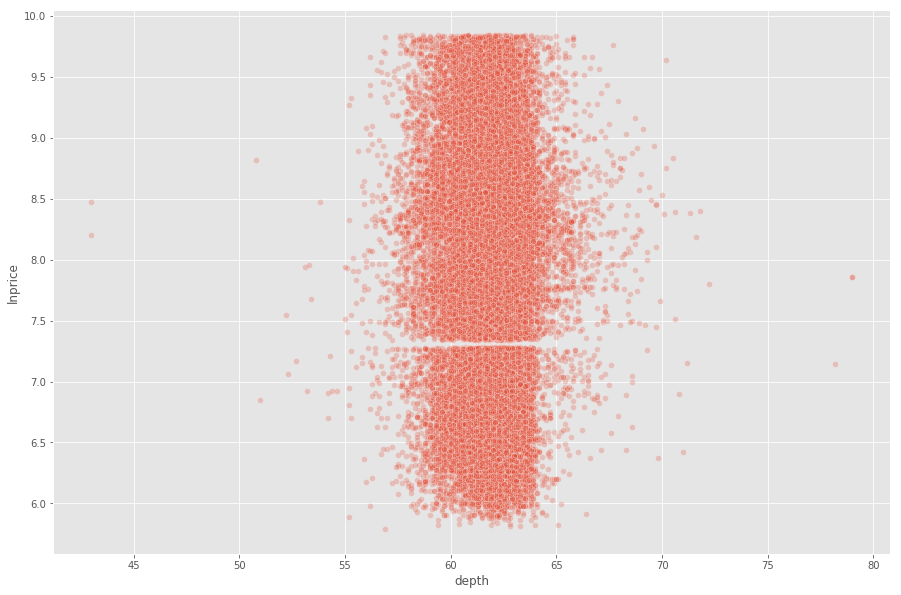

In [36]:
plt.figure(figsize=(15,10));
sns.scatterplot(x='depth', y='lnprice', data=diamonds, alpha=0.25);

Kinda looks like it goes straight up.

In [37]:
y = diamonds['lnprice'].values
X = sm.add_constant(diamonds['depth'].values)

lm_depth = sm.OLS(y, X)
lm_depth_fitted = lm_depth.fit()

lm_depth_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1932
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.660
Time:                        15:57:56   Log-Likelihood:                -57950.
No. Observations:               40455   AIC:                         1.159e+05
Df Residuals:                   40453   BIC:                         1.159e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6905      0.217     35.381      0.000       7.265       8.117
x1             0.0015      0.004      0.440      0.660      -0.005       0.008
==============================================================================
Omnibus:                    16100.214   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2109.245
Skew:                           0.118   Prob(JB):                         0.00
Kurtosis:                       1.907   Cond. No.                     2.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Yeah, hah smell ya later.

#### Root Mean Square Error

Just for fun.

In [38]:
np.sqrt(lm_depth_fitted.mse_resid)

1.013631542630724

### `table`

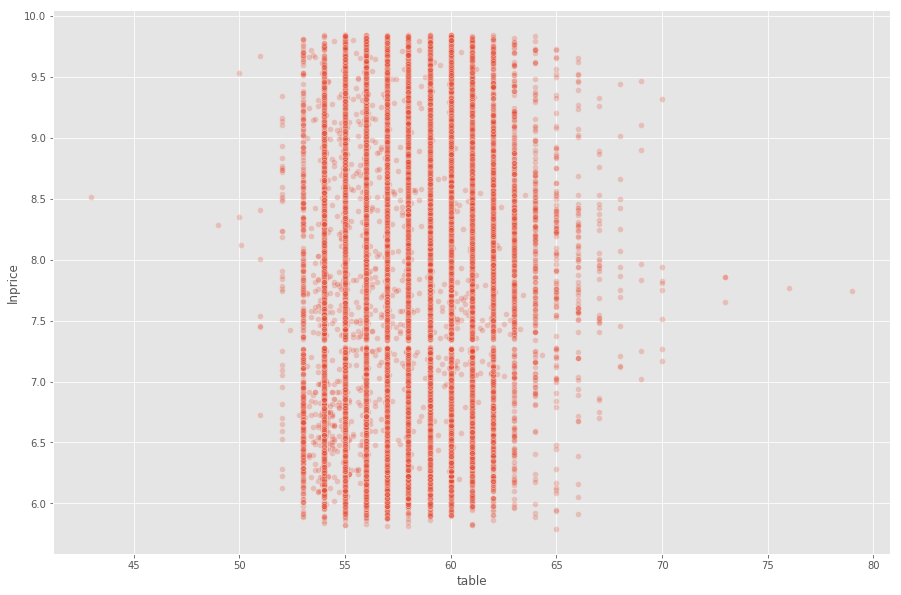

In [39]:
plt.figure(figsize=(15,10));
sns.scatterplot(x='table', y='lnprice', data=diamonds, alpha=0.25);

In [40]:
y = diamonds['lnprice'].values
X = sm.add_constant(diamonds['table'].values)

lm_table = sm.OLS(y, X)
lm_table_fitted = lm_table.fit()

lm_table_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     984.2
Date:                Tue, 18 Sep 2018   Prob (F-statistic):          1.81e-213
Time:                        15:57:57   Log-Likelihood:                -57464.
No. Observations:               40455   AIC:                         1.149e+05
Df Residuals:                   40453   BIC:                         1.149e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7595      0.128     29.269      0.000       3.508       4.011
x1             0.0701      0.002     31.372      0.000       0.066       0.074
==============================================================================
Omnibus:                    10070.131   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1833.307
Skew:                           0.124   Prob(JB):                         0.00
Kurtosis:                       1.987   Cond. No.                     1.48e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
np.sqrt(lm_table_fitted.mse_resid)

1.0015242059363598

### Takeaways

So our univariate analyses indicate that `carat`, `x`, `y`, and `z` are good features.

## Univariate Analyses of Categorical Features